In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import xgboost as xgb
import os
import pickle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.arima.model import ARIMA



# Fetch Data

In [3]:
df = pd.read_csv('output_csv/2021-22_game_by_game.csv')
df.columns = df.columns.str.lower()

In [4]:
df.head()

,game_id,team_id,team_abbreviation,team_city,player_id,player_name,nickname,start_position,comment,min,...,oreb_pct,pace,pace_per40,pie,poss,reb_pct,tm_tov_pct,ts_pct,usg_pct,game_date
0,42000406,1610612756,PHX,Phoenix,1628969,Mikal Bridges,Mikal,F,NaN,39.000000:28,...,0.024,102.76,85.63,0.055,84,0.075,0.0,0.444,0.089,2021-07-20
1,42000406,1610612756,PHX,Phoenix,203109,Jae Crowder,Jae,F,NaN,40.000000:33,...,0.053,102.39,85.33,0.140,86,0.169,13.3,0.568,0.165,2021-07-20
2,42000406,1610612756,PHX,Phoenix,1629028,Deandre Ayton,Deandre,C,NaN,36.000000:12,...,0.024,104.11,86.76,0.043,78,0.077,11.8,0.423,0.190,2021-07-20
3,42000406,1610612756,PHX,Phoenix,1626164,Devin Booker,Devin,G,NaN,46.000000:15,...,0.000,102.23,85.19,0.018,98,0.033,17.6,0.407,0.276,2021-07-20
4,42000406,1610612756,PHX,Phoenix,101108,Chris Paul,Chris,G,NaN,39.000000:13,...,0.026,102.81,85.68,0.123,84,0.026,10.7,0.626,0.258,2021-07-20


# Preprocessing

## Traceability

In [5]:
player_name_to_id = df.groupby('player_name')['player_id'].first()
player_name_to_id = player_name_to_id.to_frame()

In [6]:
player_name_to_id

,player_id
player_name,
Aaron Epps,1629200
Aaron Gordon,203932
Aaron Holiday,1628988
Aaron Nesmith,1630174
Abdel Nader,1627846
...,...
Zavier Simpson,1630285
Zeke Nnaji,1630192
Zhaire Smith,1629015


### Data Cleaning

In [7]:
df[df.isna()]

,game_id,team_id,team_abbreviation,team_city,player_id,player_name,nickname,start_position,comment,min,...,oreb_pct,pace,pace_per40,pie,poss,reb_pct,tm_tov_pct,ts_pct,usg_pct,game_date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df = df.dropna(subset=['player_name'])
df.isna().sum()

game_id                  0
team_id                  0
team_abbreviation        0
team_city                0
player_id                0
player_name              0
nickname                 0
start_position       23230
comment              29272
min                   7588
fgm                   7588
fga                   7588
fg_pct                7588
fg3m                  7588
fg3a                  7588
fg3_pct               7588
ftm                   7588
fta                   7588
ft_pct                7588
oreb                  7588
dreb                  7588
reb                   7588
ast                   7588
stl                   7588
blk                   7588
to                    7588
pf                    7588
pts                   7588
plus_minus            7588
ast_pct               7588
ast_ratio             7588
ast_tov               7588
def_rating               0
dreb_pct                 0
efg_pct               7588
e_def_rating          7588
e_net_rating          7588
e

In [9]:
na_cols = df.columns[df.isna().any()].tolist()
na_cols

['start_position',
 'comment',
 'min',
 'fgm',
 'fga',
 'fg_pct',
 'fg3m',
 'fg3a',
 'fg3_pct',
 'ftm',
 'fta',
 'ft_pct',
 'oreb',
 'dreb',
 'reb',
 'ast',
 'stl',
 'blk',
 'to',
 'pf',
 'pts',
 'plus_minus',
 'ast_pct',
 'ast_ratio',
 'ast_tov',
 'efg_pct',
 'e_def_rating',
 'e_net_rating',
 'e_off_rating',
 'e_pace',
 'pace',
 'pace_per40',
 'pie',
 'tm_tov_pct',
 'ts_pct']

In [10]:
df['start_position'] = df['start_position'].fillna('Bench')
df['min'] = df['min'].fillna('0:00')  # Fill missing values with 0 minutes
df['min'] = df['min'].apply(lambda x: int(x.split(':')[0].split('.')[0]) + int(x.split(':')[1])/60)  # Convert to numeric format
df[na_cols] = df[na_cols].fillna(0)  # Fill missing values with 0

In [11]:
cols_to_drop = ['nickname', 'comment', 'player_name', 'team_city']
df.drop(columns=cols_to_drop, inplace=True)

In [12]:
df['game_date'] = pd.to_datetime(df['game_date'])

In [13]:
cat_cols = ['team_abbreviation', 'player_id', 'start_position']
df[cat_cols] = df[cat_cols].astype('category')

cols_for_ma = ['min','fgm','fga','fg_pct','fg3m','fg3a','fg3_pct','ftm','fta','ft_pct','oreb','dreb','reb','ast','stl','blk','to','pf','pts','plus_minus','ast_pct','ast_ratio','ast_tov','def_rating','dreb_pct','efg_pct','e_def_rating','e_net_rating','e_off_rating','e_pace','e_usg_pct','net_rating','off_rating','oreb_pct','pace','pace_per40','pie','poss','reb_pct','tm_tov_pct','ts_pct','usg_pct']

In [14]:
df.isna().sum()

game_id              0
team_id              0
team_abbreviation    0
player_id            0
start_position       0
min                  0
fgm                  0
fga                  0
fg_pct               0
fg3m                 0
fg3a                 0
fg3_pct              0
ftm                  0
fta                  0
ft_pct               0
oreb                 0
dreb                 0
reb                  0
ast                  0
stl                  0
blk                  0
to                   0
pf                   0
pts                  0
plus_minus           0
ast_pct              0
ast_ratio            0
ast_tov              0
def_rating           0
dreb_pct             0
efg_pct              0
e_def_rating         0
e_net_rating         0
e_off_rating         0
e_pace               0
e_usg_pct            0
net_rating           0
off_rating           0
oreb_pct             0
pace                 0
pace_per40           0
pie                  0
poss                 0
reb_pct    

In [15]:
df

,game_id,team_id,team_abbreviation,player_id,start_position,min,fgm,fga,fg_pct,fg3m,...,oreb_pct,pace,pace_per40,pie,poss,reb_pct,tm_tov_pct,ts_pct,usg_pct,game_date
0,42000406,1610612756,PHX,1628969,F,39.466667,3.0,7.0,0.429,0.0,...,0.024,102.76,85.63,0.055,84,0.075,0.0,0.444,0.089,2021-07-20
1,42000406,1610612756,PHX,203109,F,40.550000,4.0,11.0,0.364,2.0,...,0.053,102.39,85.33,0.140,86,0.169,13.3,0.568,0.165,2021-07-20
2,42000406,1610612756,PHX,1629028,C,36.200000,4.0,12.0,0.333,0.0,...,0.024,104.11,86.76,0.043,78,0.077,11.8,0.423,0.190,2021-07-20
3,42000406,1610612756,PHX,1626164,G,46.250000,8.0,22.0,0.364,0.0,...,0.000,102.23,85.19,0.018,98,0.033,17.6,0.407,0.276,2021-07-20
4,42000406,1610612756,PHX,101108,G,39.216667,11.0,19.0,0.579,1.0,...,0.026,102.81,85.68,0.123,84,0.026,10.7,0.626,0.258,2021-07-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36855,12000001,1610612737,ATL,1630219,Bench,5.500000,0.0,3.0,0.000,0.0,...,0.125,126.55,105.45,-0.029,14,0.059,0.0,0.315,0.313,2020-12-11
36856,12000001,1610612737,ATL,1627739,Bench,0.000000,0.0,0.0,0.000,0.0,...,0.000,0.00,0.00,0.000,0,0.000,0.0,0.000,0.000,2020-12-11
36857,12000001,1610612737,ATL,1630168,Bench,0.000000,0.0,0.0,0.000,0.0,...,0.000,0.00,0.00,0.000,0,0.000,0.0,0.000,0.000,2020-12-11
36858,12000001,1610612737,ATL,200765,Bench,0.000000,0.0,0.0,0.000,0.0,...,0.000,0.00,0.00,0.000,0,0.000,0.0,0.000,0.000,2020-12-11


## Reverse the order of the df:

In [19]:
df['week'] = df['game_date'].apply(lambda x: x.weekofyear)
league_week_dict = {week: i for i, week in enumerate(df['week'].unique(), 1)}
df['league_week'] = df['week'].map(league_week_dict)
df = df.sort_values('league_week', ascending=False)
df

,game_id,team_id,team_abbreviation,player_id,start_position,min,fgm,fga,fg_pct,fg3m,...,reb_pct_rolling_10_day_avg,reb_pct_rolling_10_day_std,tm_tov_pct_rolling_10_day_avg,tm_tov_pct_rolling_10_day_std,ts_pct_rolling_10_day_avg,ts_pct_rolling_10_day_std,usg_pct_rolling_10_day_avg,usg_pct_rolling_10_day_std,week,league_week
36859,12000001,1610612737,ATL,203503,Bench,0.000000,0.0,0.0,0.000,0.0,...,0.0268,0.039406,3.33,10.530385,0.2500,0.485913,0.0599,0.067514,50,33
36425,12000009,1610612742,DAL,1626196,G,16.333333,3.0,6.0,0.500,3.0,...,0.0545,0.031003,6.34,6.132826,0.6327,0.209841,0.1793,0.031049,50,33
36423,12000009,1610612742,DAL,1627827,F,16.333333,1.0,3.0,0.333,1.0,...,0.0940,0.043914,7.28,6.537210,0.5718,0.196813,0.1268,0.025297,50,33
36422,12000009,1610612742,DAL,203501,F,16.333333,2.0,9.0,0.222,1.0,...,0.0685,0.038312,4.76,5.218173,0.6163,0.273487,0.2191,0.033371,50,33
36421,12000014,1610612751,BKN,1629725,Bench,0.000000,0.0,0.0,0.000,0.0,...,0.0489,0.047915,9.53,6.084415,0.4539,0.269574,0.2123,0.117783,50,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,42000406,1610612749,MIL,1628382,Bench,0.000000,0.0,0.0,0.000,0.0,...,0.0000,NaN,0.00,NaN,0.0000,NaN,0.0000,NaN,29,1
27,42000406,1610612749,MIL,1630241,Bench,0.000000,0.0,0.0,0.000,0.0,...,0.0000,NaN,0.00,NaN,0.0000,NaN,0.0000,NaN,29,1
28,42000406,1610612749,MIL,1629670,Bench,0.000000,0.0,0.0,0.000,0.0,...,0.0000,NaN,0.00,NaN,0.0000,NaN,0.0000,NaN,29,1
29,42000406,1610612749,MIL,1626253,Bench,0.000000,0.0,0.0,0.000,0.0,...,0.0000,NaN,0.00,NaN,0.0000,NaN,0.0000,NaN,29,1


## Add MA cols

In [20]:
rolling_window = 10  # Example window size
for col in cols_for_ma:
    df[f'{col}_rolling_{rolling_window}_day_avg'] = df.groupby('player_id')[col].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())
    df[f'{col}_rolling_{rolling_window}_day_std'] = df.groupby('player_id')[col].transform(lambda x: x.rolling(rolling_window, min_periods=1).std())


## Categorical columns

-- currently we're doing one hot encoding to all the relevant cat values, but it's not good enough and actually is unnecessary for XGB which is our best option ATM - the next two cols are optional!

In [21]:
# one hot encoding all the cat vals:

# Apply OneHotEncoder
# encoder = OneHotEncoder(drop='first', sparse=False)
# encoded_categorical = encoder.fit_transform(df[cat_cols])


In [22]:

# encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(cat_cols))

# df = pd.concat([df, encoded_categorical_df], axis=1)
# df_with_player_id = df 
# df = df.drop(columns=cat_cols)
# df.drop(columns=['comment'], inplace=True)


## Prep data for test

In [23]:
target = 'reb'
target_related_cols = cols_for_ma
features = df.columns.difference(target_related_cols).tolist()

# Split data into features and target
X = df[features]
y = df[target]



In [24]:
features

['ast_pct_rolling_10_day_avg',
 'ast_pct_rolling_10_day_std',
 'ast_ratio_rolling_10_day_avg',
 'ast_ratio_rolling_10_day_std',
 'ast_rolling_10_day_avg',
 'ast_rolling_10_day_std',
 'ast_tov_rolling_10_day_avg',
 'ast_tov_rolling_10_day_std',
 'blk_rolling_10_day_avg',
 'blk_rolling_10_day_std',
 'def_rating_rolling_10_day_avg',
 'def_rating_rolling_10_day_std',
 'dreb_pct_rolling_10_day_avg',
 'dreb_pct_rolling_10_day_std',
 'dreb_rolling_10_day_avg',
 'dreb_rolling_10_day_std',
 'e_def_rating_rolling_10_day_avg',
 'e_def_rating_rolling_10_day_std',
 'e_net_rating_rolling_10_day_avg',
 'e_net_rating_rolling_10_day_std',
 'e_off_rating_rolling_10_day_avg',
 'e_off_rating_rolling_10_day_std',
 'e_pace_rolling_10_day_avg',
 'e_pace_rolling_10_day_std',
 'e_usg_pct_rolling_10_day_avg',
 'e_usg_pct_rolling_10_day_std',
 'efg_pct_rolling_10_day_avg',
 'efg_pct_rolling_10_day_std',
 'fg3_pct_rolling_10_day_avg',
 'fg3_pct_rolling_10_day_std',
 'fg3a_rolling_10_day_avg',
 'fg3a_rolling_10_da

# Models

## XGB
We'll have a continously training model that will be updated with new data. We'll keep updating the model and training it every week

In [25]:
league_week_gb = X.groupby('league_week')['game_date'].unique().reset_index()
league_week_gb['max_day'] = league_week_gb['game_date'].apply(lambda x: x.max())
league_week_gb['min_day'] = league_week_gb['game_date'].apply(lambda x: x.min())
league_week_gb.sort_values('league_week', ascending=False, inplace=True)
league_week_gb

,league_week,game_date,max_day,min_day
32,33,"[2020-12-11T00:00:00.000000000, 2020-12-12T00:...",2020-12-13,2020-12-11
31,32,"[2020-12-18T00:00:00.000000000, 2020-12-17T00:...",2020-12-19,2020-12-14
30,31,"[2020-12-26T00:00:00.000000000, 2020-12-27T00:...",2020-12-27,2020-12-22
29,30,"[2021-01-01T00:00:00.000000000, 2021-01-02T00:...",2021-01-03,2020-12-28
28,29,"[2021-01-08T00:00:00.000000000, 2021-01-09T00:...",2021-01-10,2021-01-04
27,28,"[2021-01-15T00:00:00.000000000, 2021-01-16T00:...",2021-01-17,2021-01-11
26,27,"[2021-01-22T00:00:00.000000000, 2021-01-23T00:...",2021-01-24,2021-01-18
25,26,"[2021-01-29T00:00:00.000000000, 2021-01-30T00:...",2021-01-31,2021-01-25
24,25,"[2021-02-05T00:00:00.000000000, 2021-02-06T00:...",2021-02-07,2021-02-01
23,24,"[2021-02-12T00:00:00.000000000, 2021-02-13T00:...",2021-02-14,2021-02-08


In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36860 entries, 36859 to 0
Data columns (total 92 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ast_pct_rolling_10_day_avg       36860 non-null  float64       
 1   ast_pct_rolling_10_day_std       36130 non-null  float64       
 2   ast_ratio_rolling_10_day_avg     36860 non-null  float64       
 3   ast_ratio_rolling_10_day_std     36130 non-null  float64       
 4   ast_rolling_10_day_avg           36860 non-null  float64       
 5   ast_rolling_10_day_std           36130 non-null  float64       
 6   ast_tov_rolling_10_day_avg       36860 non-null  float64       
 7   ast_tov_rolling_10_day_std       36130 non-null  float64       
 8   blk_rolling_10_day_avg           36860 non-null  float64       
 9   blk_rolling_10_day_std           36130 non-null  float64       
 10  def_rating_rolling_10_day_avg    36860 non-null  float64  

In [26]:
num_weeks_for_training = 16

# Identify the range of weeks for training
start_week = league_week_gb['league_week'].max()
end_week = start_week - num_weeks_for_training + 1  # inclusive range

# Select training data
training_weeks = list(range(start_week, end_week - 1, -1))
X_train = X[X['league_week'].isin(training_weeks)]
game_ids_and_date_train = X_train[['game_date', 'game_id']] 
X_train_without_game_time = X_train.drop(columns=['game_date', 'game_id'])

y_train = y.loc[X_train.index]

# Select test data (the week immediately following the training period)
X_test = X[X['league_week'] == end_week - 1]
game_ids_and_date_test = X_test[['game_date', 'game_id']] 
X_test_without_game_time = X_test.drop(columns=['game_date', 'game_id'])
y_test = y.loc[X_test.index]

# Check if the lengths are appropriate
print(f'Training weeks: {training_weeks}')
print(f'X_train shape: {X_train_without_game_time.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test_without_game_time.shape}, y_test shape: {y_test.shape}')


Training weeks: [33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18]
X_train shape: (23417, 90), y_train shape: (23417,)
X_test shape: (1523, 90), y_test shape: (1523,)


In [27]:
# Create DMatrix for training and testing data
dtrain = xgb.DMatrix(X_train_without_game_time, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test_without_game_time, label=y_test, enable_categorical=True)

# Specify the booster parameters with tree_method set to 'gpu_hist' if using GPU
params = {
    'tree_method': 'hist',  # Use 'gpu_hist' if you have a GPU
    'enable_categorical': True
}

# Train the model
model = xgb.train(params, dtrain)

In [31]:
y_pred = model.predict(dtest)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R²): {r2:.2f}')


Mean Squared Error (MSE): 5.17
Root Mean Squared Error (RMSE): 2.27
R-squared (R²): 0.55


In [32]:
game_ids_and_date_test

,game_date,game_id
12427,2021-04-02,22000743
12430,2021-04-02,22000743
12429,2021-04-02,22000743
12428,2021-04-02,22000743
12425,2021-04-02,22000743
...,...,...
12938,2021-03-31,22000728
12940,2021-03-31,22000723
12936,2021-03-31,22000728
12935,2021-03-31,22000728


In [33]:
res = y_test.to_frame()
res['y_pred'] = y_pred
res[['game_date', 'game_id']] =game_ids_and_date_test
res

,reb,y_pred,game_date,game_id
12427,5.0,5.894968,2021-04-02,22000743
12430,0.0,0.508486,2021-04-02,22000743
12429,3.0,1.491486,2021-04-02,22000743
12428,2.0,3.424841,2021-04-02,22000743
12425,2.0,3.172887,2021-04-02,22000743
...,...,...,...,...
12938,0.0,0.423500,2021-03-31,22000728
12940,3.0,5.601340,2021-03-31,22000723
12936,0.0,2.867701,2021-03-31,22000728
12935,1.0,1.749215,2021-03-31,22000728


                            Feature  Importance
55                        player_id       203.0
63           reb_rolling_10_day_avg        54.0
64           reb_rolling_10_day_std        42.0
65                   start_position        40.0
68                team_abbreviation        27.0
14          dreb_rolling_10_day_std        17.0
20        e_pace_rolling_10_day_avg         9.0
1        ast_pct_rolling_10_day_std         8.0
0        ast_pct_rolling_10_day_avg         8.0
9     def_rating_rolling_10_day_avg         7.0
2      ast_ratio_rolling_10_day_avg         7.0
40           min_rolling_10_day_std         7.0
62       reb_pct_rolling_10_day_std         7.0
4            ast_rolling_10_day_std         6.0
57    plus_minus_rolling_10_day_std         6.0
18  e_net_rating_rolling_10_day_std         6.0
61       reb_pct_rolling_10_day_avg         5.0
73        ts_pct_rolling_10_day_std         5.0
54           pie_rolling_10_day_std         5.0
48          oreb_rolling_10_day_std     

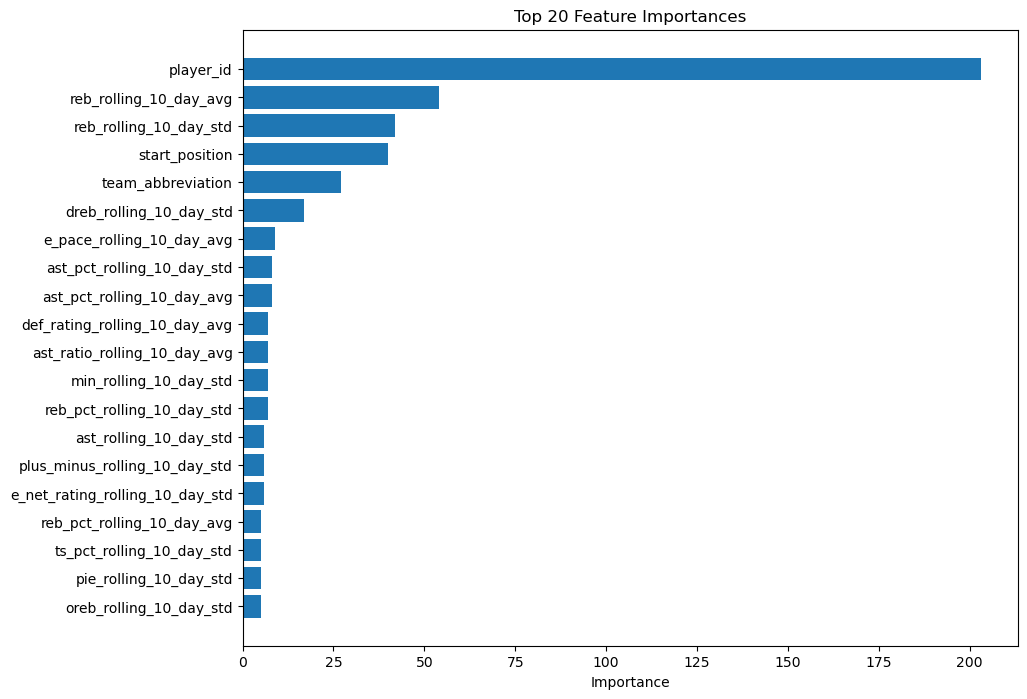

In [34]:
importance_dict = model.get_score(importance_type='weight')

# Convert to DataFrame for easier manipulation
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select top 20 features
top_20_features = importance_df.head(20)

# Display top 20 features
print(top_20_features)

# Plot top 20 features
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

In [35]:
def rolling_train_test(X, y, league_week_gb, num_weeks_for_training=16, save_model=True, model_dir='models'):
    # Ensure the model directory exists
    os.makedirs(model_dir, exist_ok=True)

    # Initialize lists to store predictions and true values
    all_predictions = []
    all_true_values = []
    all_game_ids = []
    all_game_dates = []
    all_player_ids = []

    # Get the maximum and minimum weeks
    max_week = league_week_gb['league_week'].max()
    min_week = league_week_gb['league_week'].min()

    for start_week in range(max_week, min_week + num_weeks_for_training - 1, -1):
        end_week = start_week - num_weeks_for_training + 1  # inclusive range

        if end_week < min_week:
            break  # Stop if the end_week is less than the minimum week

        # Select training data
        training_weeks = list(range(start_week, end_week - 1, -1))
        X_train = X[X['league_week'].isin(training_weeks)]
        identifying_train_data = X_train[['player_id', 'game_date', 'game_id']] 
        X_train = X_train.drop(columns = ['game_date', 'game_id'])
        y_train = y.loc[X_train.index]

        # Select test data (the week immediately following the training period)
        X_test = X[X['league_week'] == end_week - 1]
        identifying_test_data = X_test[['player_id', 'game_date', 'game_id']] 
        X_test = X_test.drop(columns = ['game_date', 'game_id'])

        y_test = y.loc[X_test.index]

        # Create DMatrix for training and testing data
        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

        # Specify the booster parameters with tree_method set to 'gpu_hist' if using GPU
        params = {
            'tree_method': 'hist',  # Use 'gpu_hist' if you have a GPU
            'enable_categorical': True
        }

        # Train the model
        model = xgb.train(params, dtrain)

        # Make predictions
        y_pred = model.predict(dtest)

        # Store the predictions and true values
        all_predictions.extend(y_pred)
        all_true_values.extend(y_test)
        all_game_ids.extend(list(identifying_test_data['game_id']))
        all_game_dates.extend(list(identifying_test_data['game_date']))
        all_player_ids.extend(list(identifying_test_data['player_id']))


        # Save the model if requested
        if save_model:
            model_filename = f'{model_dir}/model_week_{start_week}_to_{end_week}.pkl'
            with open(model_filename, 'wb') as file:
                pickle.dump(model, file)

        # Calculate evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Print the evaluation metrics
        print(f'Training weeks: {training_weeks}')
        print(f'Test weeks: {end_week - 1}')
        print(f'Min day in training data: {league_week_gb[league_week_gb["league_week"].isin(training_weeks)]["min_day"].values[0]}')
        print(f'Max day in training data: {league_week_gb[league_week_gb["league_week"].isin(training_weeks)]["max_day"].values[0]}')
        print(f'Min day in test data: {league_week_gb[league_week_gb["league_week"] == end_week - 1]["min_day"].values[0]}')
        print(f'Max day in test data: {league_week_gb[league_week_gb["league_week"] == end_week - 1]["max_day"].values[0]}')
        print(f'Mean Squared Error (MSE): {mse:.2f}')
        print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
        print(f'R-squared (R²): {r2:.2f}')
        print('')
        
        print(f'identifying_test_data {identifying_test_data.shape}' )
        print(f'y_test')
    # Combine predictions and true values into a DataFrame
    results_df = pd.DataFrame({
        'player_id': all_player_ids,
        'game_id': all_game_ids,
        'game_date': all_game_dates,
        'y': all_true_values,
        'y_pred': all_predictions,
        
    })
    results_df['player_name'] = results_df['player_id'].apply(lambda x: player_name_to_id[player_name_to_id['player_id'] == x].index[0])
    return results_df


In [46]:
dfs_cats = ['reb', 'pts', 'ast', 'stl', 'blk', 'to']
same_game_cols = ['min', 'fgm',
       'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta', 'ft_pct',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'to', 'pf', 'pts',
       'plus_minus', 'ast_pct', 'ast_ratio', 'ast_tov', 'def_rating',
       'dreb_pct', 'efg_pct', 'e_def_rating', 'e_net_rating', 'e_off_rating',
       'e_pace', 'e_usg_pct', 'net_rating', 'off_rating', 'oreb_pct', 'pace',
       'pace_per40', 'pie', 'poss', 'reb_pct', 'tm_tov_pct', 'ts_pct',
       'usg_pct']
total_results = {}
for cat in dfs_cats:
    target = cat
    target_related_cols = same_game_cols
    features = df.columns.difference(target_related_cols).tolist()
    feats_to_print = [c for c in features if 'player_id' not in c]
    # Split data into features and target
    X = df[features]
    y = df[target]

    # Train the model
    print(f'Training models for {cat}')
    print('---------------------------------')
    # print(f'The removed cols are: {target_related_cols}')
    # print(f'The features are: {feats_to_print}')
    results = rolling_train_test(X, y, league_week_gb, num_weeks_for_training=16, save_model=False)
    results.to_csv(f'output_csv/{cat}_results.csv', index=False)
    total_results.update({f'{cat}_full data': results})

Training models for reb
---------------------------------
Training weeks: [33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18]
Test weeks: 17
Min day in training data: 2020-12-11T00:00:00.000000000
Max day in training data: 2020-12-13T00:00:00.000000000
Min day in test data: 2021-03-29T00:00:00.000000000
Max day in test data: 2021-04-04T00:00:00.000000000
Mean Squared Error (MSE): 5.17
Root Mean Squared Error (RMSE): 2.27
R-squared (R²): 0.55

identifying_test_data (1523, 3)
y_test
Training weeks: [32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]
Test weeks: 16
Min day in training data: 2020-12-14T00:00:00.000000000
Max day in training data: 2020-12-19T00:00:00.000000000
Min day in test data: 2021-04-05T00:00:00.000000000
Max day in test data: 2021-04-11T00:00:00.000000000
Mean Squared Error (MSE): 5.31
Root Mean Squared Error (RMSE): 2.30
R-squared (R²): 0.56

identifying_test_data (1533, 3)
y_test
Training weeks: [31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21,

In [48]:
total_results

{'reb_full data':        player_id   game_id  game_date    y    y_pred      player_name
 0         202324  22000743 2021-04-02  5.0  5.894968   Derrick Favors
 1        1629671  22000743 2021-04-02  0.0  0.508486         Miye Oni
 2        1627777  22000743 2021-04-02  3.0  1.491486    Georges Niang
 3         203903  22000743 2021-04-02  2.0  3.424841  Jordan Clarkson
 4         201144  22000743 2021-04-02  2.0  3.172887      Mike Conley
 ...          ...       ...        ...  ...       ...              ...
 13438    1628382  42000406 2021-07-20  0.0  0.142233   Justin Jackson
 13439    1630241  42000406 2021-07-20  0.0  0.374224      Sam Merrill
 13440    1629670  42000406 2021-07-20  0.0 -0.086099     Jordan Nwora
 13441    1626253  42000406 2021-07-20  0.0  0.142233     Axel Toupane
 13442    1628969  42000406 2021-07-20  6.0  3.680616    Mikal Bridges
 
 [13443 rows x 6 columns],
 'pts_full data':        player_id   game_id  game_date     y     y_pred      player_name
 0         2

In [49]:
dfs = []

# Iterate over the dictionary items
for key, df in total_results.items():
    # Extract the prefix from the key
    prefix = key.split('_')[0]
    # Rename the columns
    df.rename(columns={'y': prefix, 'y_pred': f'{prefix}_pred'}, inplace=True)
    # Append the DataFrame to the list
    dfs.append(df)

# Start with the first DataFrame in the list
combined_df = dfs[0]

# Iteratively merge the remaining DataFrames
for df in dfs[1:]:
    combined_df = pd.merge(combined_df, df, on=['game_id', 'player_id', 'player_name', 'game_date'], how='outer')

In [53]:
combined_df

,player_id,game_id,game_date,reb,reb_pred,player_name,pts,pts_pred,ast,ast_pred,stl,stl_pred,blk,blk_pred,to,to_pred
0,202324,22000743,2021-04-02,5.0,5.894968,Derrick Favors,4.0,4.727058,0.0,0.875850,1.0,0.481837,2.0,1.742050,0.0,0.462477
1,1629671,22000743,2021-04-02,0.0,0.508486,Miye Oni,0.0,1.523207,0.0,0.381356,0.0,0.154260,0.0,0.115687,0.0,0.045665
2,1627777,22000743,2021-04-02,3.0,1.491486,Georges Niang,3.0,4.696698,1.0,0.880060,0.0,0.359567,0.0,0.199984,1.0,0.426469
3,203903,22000743,2021-04-02,2.0,3.424841,Jordan Clarkson,19.0,11.713884,1.0,1.880491,1.0,0.418440,0.0,0.013563,2.0,1.714314
4,201144,22000743,2021-04-02,2.0,3.172887,Mike Conley,13.0,15.386163,5.0,4.992255,1.0,1.082622,1.0,0.366885,1.0,2.160271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13438,1628382,42000406,2021-07-20,0.0,0.142233,Justin Jackson,0.0,0.231057,0.0,0.056268,0.0,0.013374,0.0,0.018517,0.0,0.100477
13439,1630241,42000406,2021-07-20,0.0,0.374224,Sam Merrill,0.0,0.423289,0.0,0.056268,0.0,0.185417,0.0,0.018517,0.0,0.033651
13440,1629670,42000406,2021-07-20,0.0,-0.086099,Jordan Nwora,0.0,0.643771,0.0,0.042212,0.0,0.001799,0.0,0.018517,0.0,0.013033
13441,1626253,42000406,2021-07-20,0.0,0.142233,Axel Toupane,0.0,0.213954,0.0,0.086592,0.0,0.031271,0.0,0.021052,0.0,0.042743


In [54]:
combined_df['fp_fanduel'] = combined_df.apply(lambda row: row['pts'] + row['reb'] * 1.2 + row['ast'] * 1.5 + row['stl'] * 3 + row['blk'] * 3 - row['to'] * 1, axis = 1)
combined_df['fp_fanduel_pred'] = combined_df.apply(lambda row: row['pts_pred'] + row['reb_pred'] * 1.2 + row['ast_pred'] * 1.5 + row['stl_pred'] * 3 + row['blk_pred'] * 3 - row['to_pred'] * 1, axis =1 )
combined_df

,player_id,game_id,game_date,reb,reb_pred,player_name,pts,pts_pred,ast,ast_pred,stl,stl_pred,blk,blk_pred,to,to_pred,fp_fanduel,fp_fanduel_pred
0,202324,22000743,2021-04-02,5.0,5.894968,Derrick Favors,4.0,4.727058,0.0,0.875850,1.0,0.481837,2.0,1.742050,0.0,0.462477,19.0,19.323977
1,1629671,22000743,2021-04-02,0.0,0.508486,Miye Oni,0.0,1.523207,0.0,0.381356,0.0,0.154260,0.0,0.115687,0.0,0.045665,0.0,3.469601
2,1627777,22000743,2021-04-02,3.0,1.491486,Georges Niang,3.0,4.696698,1.0,0.880060,0.0,0.359567,0.0,0.199984,1.0,0.426469,7.1,9.058756
3,203903,22000743,2021-04-02,2.0,3.424841,Jordan Clarkson,19.0,11.713884,1.0,1.880491,1.0,0.418440,0.0,0.013563,2.0,1.714314,23.9,18.226125
4,201144,22000743,2021-04-02,2.0,3.172887,Mike Conley,13.0,15.386163,5.0,4.992255,1.0,1.082622,1.0,0.366885,1.0,2.160271,27.9,28.870261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13438,1628382,42000406,2021-07-20,0.0,0.142233,Justin Jackson,0.0,0.231057,0.0,0.056268,0.0,0.013374,0.0,0.018517,0.0,0.100477,0.0,0.481334
13439,1630241,42000406,2021-07-20,0.0,0.374224,Sam Merrill,0.0,0.423289,0.0,0.056268,0.0,0.185417,0.0,0.018517,0.0,0.033651,0.0,1.534909
13440,1629670,42000406,2021-07-20,0.0,-0.086099,Jordan Nwora,0.0,0.643771,0.0,0.042212,0.0,0.001799,0.0,0.018517,0.0,0.013033,0.0,0.651686
13441,1626253,42000406,2021-07-20,0.0,0.142233,Axel Toupane,0.0,0.213954,0.0,0.086592,0.0,0.031271,0.0,0.021052,0.0,0.042743,0.0,0.628746


In [55]:
final_mse = mean_squared_error(combined_df['fp_fanduel'], combined_df['fp_fanduel_pred'])
final_rmse = np.sqrt(mse)
final_r2 = r2_score(combined_df['fp_fanduel'], combined_df['fp_fanduel_pred'])


In [56]:
final_mse, final_r2

(86.56284408567359, 0.6513658855090647)

In [57]:
combined_df.to_csv('fp_pred.csv')

In [ ]:
df = pd.read_csv('output_csv/2021-22_game_by_game.csv')

In [ ]:
pd.read_csv()

## Linear Regression

In [115]:
# # replacing the above with vectorized direct calculation which took under 1 second to complete
# # might be more complicated with DK and the cats > 10 thing
# 


In [116]:
# X_train.info()

In [117]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [118]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 3.6601230138778322
R^2 Score: 0.71380168237963


In [123]:
res_df = y_test.to_frame()
res_df['y_pred'] = y_pred
res_df['diff'] = res_df['y_pred'] - res_df['reb']


In [124]:
res_df

,reb,y_pred,diff
263,0.0,-0.184474,-0.184474
24046,3.0,3.429222,0.429222
28303,1.0,1.205533,0.205533
15481,0.0,-1.033883,-1.033883
24211,5.0,4.384461,-0.615539
...,...,...,...
24932,3.0,4.040088,1.040088
31759,3.0,2.275037,-0.724963
36102,0.0,-1.105132,-1.105132
8406,7.0,7.499583,0.499583


## ARIMA

In [66]:
player_ids = df_with_player_id['player_id'].unique()

df_with_player_id = df_with_player_id.drop(columns = ['team_abbreviation', 'team_city', 'start_position'])

In [79]:
train_df, test_df = train_test_split(df_with_player_id, test_size=0.2, shuffle=False)


In [80]:
example_player_id = player_ids[145]
player_name_to_id[player_name_to_id['player_id'] == example_player_id]
# player_name_to_id[player_name_to_id['player_name'] == 'Jason Tatum']

,player_id
player_name,
Jusuf Nurkic,203994


In [82]:
player_data = train_df[train_df['player_id'] == example_player_id]
player_data


,game_id,team_id,player_id,min,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,...,player_id_1630319,player_id_1630323,player_id_1630324,player_id_1630342,player_id_1630351,player_id_1630362,player_id_1630466,start_position_F,start_position_G,start_position_nan
1320,42000166,1610612757,203994,33.350000,5.0,7.0,0.714,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1541,42000165,1610612757,203994,24.166667,5.0,12.0,0.417,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1821,42000164,1610612757,203994,26.650000,6.0,8.0,0.750,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970,42000163,1610612757,203994,31.650000,5.0,10.0,0.500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2223,42000162,1610612757,203994,24.583333,2.0,8.0,0.250,1.0,2.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26508,22000337,1610612757,203994,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26997,22000559,1610612757,203994,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27214,22000316,1610612757,203994,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27426,22000298,1610612757,203994,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [84]:
# Train ARIMA model on player's rebound history
model = ARIMA(player_data['reb'], order=(5,1,0))  # ARIMA(p,d,q)
model_fit = model.fit()
# 
# # Make predictions
# preds = model_fit.predict(start=len(player_data), end=len(player_data) + len(test_df) - 1, dynamic=False)
# 
# # Evaluate predictions
# actuals = test_df[test_df['player_id'] == example_player_id]['reb']
# print(f'Player {example_player_id} MSE: {np.mean((preds - actuals)**2)}')


C:\Users\User\anaconda3\envs\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Is this garbage? this feels like garbage

## Prophet

In [ ]:
from fbprophet import Prophet

prophet_df = player_data[['GAME_DATE', 'REB']].rename(columns={'GAME_DATE': 'ds', 'REB': 'y'})
prophet_model = Prophet()


# EDA

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36860 entries, 0 to 36859
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   GAME_ID            36860 non-null  int64         
 1   TEAM_ID            36860 non-null  int64         
 2   TEAM_ABBREVIATION  36860 non-null  object        
 3   TEAM_CITY          36860 non-null  object        
 4   PLAYER_ID          36860 non-null  int64         
 5   PLAYER_NAME        36860 non-null  object        
 6   NICKNAME           36860 non-null  object        
 7   START_POSITION     13630 non-null  object        
 8   COMMENT            7588 non-null   object        
 9   MIN                36860 non-null  float64       
 10  FGM                29272 non-null  float64       
 11  FGA                29272 non-null  float64       
 12  FG_PCT             29272 non-null  float64       
 13  FG3M               29272 non-null  float64       
 14  FG3A  

In [47]:
df.describe()

,GAME_ID,TEAM_ID,PLAYER_ID,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,OREB_PCT,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,USG_PCT,FP_fanduel
count,3.686000e+04,3.686000e+04,3.686000e+04,36860.000000,29272.000000,29272.000000,29272.000000,29272.000000,29272.000000,29272.000000,...,36860.000000,29272.000000,29272.000000,29272.000000,36860.000000,36860.000000,29272.000000,29272.000000,36860.000000,36860.000000
mean,2.120403e+08,1.610811e+09,1.167889e+06,17.848077,3.815079,8.235344,0.428196,1.178293,3.248394,0.260143,...,0.031788,103.395003,86.162451,0.088864,37.630521,0.070144,10.025000,0.528814,0.145529,16.702333
std,5.849399e+08,6.133752e+05,6.706463e+05,13.083206,3.179613,5.884624,0.251505,1.483243,3.006200,0.291851,...,0.057542,88.501947,73.751627,0.162012,27.471117,0.071564,12.678528,0.285133,0.107200,15.382671
min,1.200000e+07,1.610613e+09,2.544000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,47.010000,39.180000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000
25%,2.200028e+07,1.610613e+09,2.035240e+05,3.616667,1.000000,4.000000,0.286000,0.000000,1.000000,0.000000,...,0.000000,97.210000,81.010000,0.036000,8.000000,0.000000,0.000000,0.375000,0.054750,1.200000
50%,2.200063e+07,1.610613e+09,1.628400e+06,19.383333,3.000000,7.000000,0.444000,1.000000,3.000000,0.200000,...,0.000000,101.390000,84.490000,0.090000,41.000000,0.059000,7.700000,0.543000,0.154000,14.400000
75%,2.200097e+07,1.610613e+09,1.629647e+06,28.800000,6.000000,12.000000,0.571000,2.000000,5.000000,0.500000,...,0.048000,105.970000,88.310000,0.142000,61.000000,0.108000,14.800000,0.698000,0.220000,26.700000
max,2.042000e+09,1.612710e+09,1.630466e+06,53.000000,21.000000,37.000000,1.000000,12.000000,22.000000,1.000000,...,1.000000,14405.760000,12004.800000,6.500000,108.000000,1.000000,100.000000,2.273000,1.000000,96.400000


In [52]:
df.drop(columns=['PLAYER_NAME'], inplace=True)
df.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,NICKNAME,START_POSITION,COMMENT,MIN,FGM,...,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,USG_PCT,GAME_DATE,FP_fanduel
0,42000406,1610612756,38,34,377,339,1,21,39.466667,3.0,...,102.76,85.63,0.055,84,0.075,0.0,0.444,0.089,2021-07-20,23.2
1,42000406,1610612756,38,34,110,206,1,21,40.550000,4.0,...,102.39,85.33,0.140,86,0.169,13.3,0.568,0.165,2021-07-20,43.6
2,42000406,1610612756,38,34,424,113,0,21,36.200000,4.0,...,104.11,86.76,0.043,78,0.077,11.8,0.423,0.190,2021-07-20,30.7
3,42000406,1610612756,38,34,209,123,2,21,46.250000,8.0,...,102.23,85.19,0.018,98,0.033,17.6,0.407,0.276,2021-07-20,24.1
4,42000406,1610612756,38,34,7,73,2,21,39.216667,11.0,...,102.81,85.68,0.123,84,0.026,10.7,0.626,0.258,2021-07-20,35.9


In [53]:
categorical_columns = ['TEAM_ABBREVIATION', 'TEAM_CITY', 'NICKNAME', 'START_POSITION', 'COMMENT', 'PLAYER_ID']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [54]:
features = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 
            'OREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS'] + categorical_columns
target = 'REB'


In [55]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [57]:
scaler = StandardScaler()
train_df[features[:-len(categorical_columns)]] = scaler.fit_transform(train_df[features[:-len(categorical_columns)]])
test_df[features[:-len(categorical_columns)]] = scaler.transform(test_df[features[:-len(categorical_columns)]])

In [58]:
train_df

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,NICKNAME,START_POSITION,COMMENT,MIN,FGM,...,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,USG_PCT,GAME_DATE,FP_fanduel
7680,22000905,1610612755,37,33,567,399,3,21,-0.892109,-0.881690,...,127.98,106.65,0.094,16,0.000,0.0,1.087,0.167,2021-04-24,6.0
8394,22000882,1610612754,20,19,328,148,1,21,0.569360,0.062448,...,107.41,89.50,0.056,56,0.033,10.0,0.625,0.143,2021-04-21,15.9
12754,22000732,1610612751,3,4,41,108,3,6,-1.366064,NaN,...,NaN,NaN,NaN,0,0.000,NaN,NaN,0.000,2021-04-01,0.0
19481,22000525,1610612763,27,25,401,107,3,21,0.352184,0.377161,...,111.35,92.79,0.204,53,0.065,12.5,0.751,0.190,2021-02-28,35.1
20020,22000506,1610612761,46,43,120,28,3,21,-0.193312,0.062448,...,108.24,90.20,0.158,35,0.158,0.0,0.563,0.205,2021-02-26,19.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,22000194,1610612754,20,19,250,63,2,21,0.693279,0.377161,...,109.88,91.56,0.050,62,0.132,18.2,0.412,0.299,2021-03-13,20.4
6265,22000963,1610612760,34,31,729,165,3,21,0.463327,0.062448,...,110.61,92.18,0.061,56,0.182,6.3,0.311,0.203,2021-05-01,25.0
11284,22000780,1610612763,27,25,653,507,3,21,-0.028513,-0.566977,...,101.78,84.81,0.112,37,0.200,20.0,1.000,0.071,2021-04-07,16.2
860,42000214,1610612749,30,27,51,228,3,6,-1.366064,NaN,...,NaN,NaN,NaN,0,0.000,NaN,NaN,0.000,2021-06-13,0.0


/Users/yafo/miniconda3/envs/nlp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yafo/miniconda3/envs/nlp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yafo/miniconda3/envs/nlp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yafo/miniconda3/envs/nlp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE: 16.22515373160827


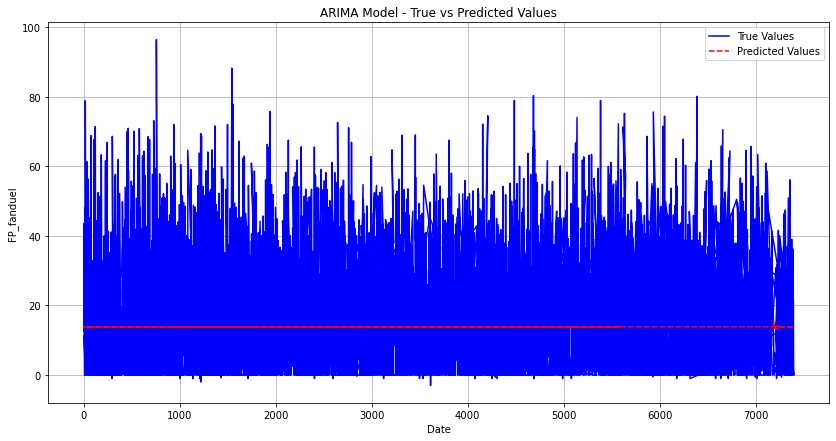

In [9]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Sort the data by game_date
dataset = dataset.sort_values('GAME_DATE')

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(dataset) * 0.8)
train, test = dataset[:train_size], dataset[train_size:]

# Extract the target variable
y_train = train['FP_fanduel']
y_test = test['FP_fanduel']

# Fit an ARIMA model
model = ARIMA(y_train, order=(5, 1, 0))
model_fit = model.fit()

# Make predictions
y_pred = model_fit.forecast(steps=len(test))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'RMSE: {rmse}')

# Plotting the true values and predictions
plt.figure(figsize=(14, 7))
plt.plot(test.index, y_test, label='True Values', color='blue')
plt.plot(test.index, y_pred, label='Predicted Values', color='red', linestyle='--')
plt.title('ARIMA Model - True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('FP_fanduel')
plt.legend()
plt.grid(True)
plt.show()